In [1]:
"""Create parameters.py and load it"""

# Directory for .inp file:
path = 'D:/parameter_studies/Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O.inp'

# import libraries:
import importlib   # For reloading your own files
from termcolor import colored   # for colored error messages
# my own files:
try:
    import inp_data_extractor as inp
except:
    try:
        import Bubble_dynamics_simulation.inp_data_extractor as inp
    except:
        print(colored(f'Error, \'inp_data_extractor.py\' not found', 'red'))
importlib.reload(inp)   # reload changes you made
inp.extract(path)

import parameters as par   # numeric constants and coefficents
importlib.reload(par)   # reload changes you made
print(par.model)

path=D:/parameter_studies/Bubble_dynamics_simulation/INP file examples/chem_Otomo2018_without_O.inp
Note, lambda value for specie 'H' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH2' is not in data.py: 0.0 is used
Note, lambda value for specie 'NH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N' is not in data.py: 0.0 is used
Note, lambda value for specie 'NNH' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H4' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H3' is not in data.py: 0.0 is used
Note, lambda value for specie 'N2H2' is not in data.py: 0.0 is used
Note, lambda value for specie 'H2NN' is not in data.py: 0.0 is used
Warning, third body 'H2O' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
Warning, third body 'AR' is not in species in line 64 (' H2/2.5/ H2O/12/ AR/0.0/ ') in reaction 'H2+M=H+H+M'
model: chem_Otomo2018_without_O
File 'parameters.py' succesfully created
chem_O

In [2]:
"""Libraries"""

# for plotting:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import numpy as np   # matrices, math
import os    # file management
import pandas as pd   # data frames
import importlib   # for reloading your own files
from termcolor import colored   # for colored error messages

# my own file:
already_imported = 'de' in globals()
try:
    import full_bubble_model as de
except:
    try:
        import Bubble_dynamics_simulation.full_bubble_model as de
    except:
        print(colored(f'Error, \'full_bubble_model.py\' not found', 'red'))
if already_imported: importlib.reload(de)   # reload changes you made

model: chem_Otomo2018_without_O
target specie: NH3
excitation: sin_impulse_logf (control parameters: ['p_A', 'logf', 'n'])
enable heat transfer: True	enable evaporation: False	enable reactions: True	enable dissipated energy: True


In [6]:
"""Base settings"""

directory = 'D:\\parameter_studies\\Bubble_dynamics_simulation\\test 1'
file_base_name = 'output_'

In [7]:
"""Load all CSV files from directory into a dataframe (all_data)"""

# create a dataframe
all_data = pd.DataFrame()
num = 0
print(f'Found files:')

# iterate trough all files in directory (including subdirectories)
for (root, dirs, files) in os.walk(directory):
    for file in files:
        # ignore python rubish
        if 'ipynb_checkpoints' in root:
            continue
        # check if it's a CSV starting with file_base_name
        if file[-4:] != '.csv':
            continue
        if file[:len(file_base_name)] != file_base_name:
            continue

        # read file
        num += 1
        current_data = pd.read_csv(os.path.join(root, file))

        # Cast object-dtype columns with all-bool values to bool dtype
        for col in current_data.columns:
            if current_data[col].dtype == 'object' and all(current_data[col].dropna().map(lambda x: isinstance(x, bool))):
                current_data[col] = current_data[col].astype(bool)

        print(f'\t{file: <24} ({current_data.shape[0]: >4} rows)')
        all_data = pd.concat([all_data, current_data])
    
    
# Print some stats:
print(f'_______________________________________')
print(f'total number of files: {num}')
total = all_data.shape[0]
print(f'{"total:": <10} {total: < 8} rows   ( 100.00 %)')

# Print errors
def matches(error, error_code):
    errors, success = de.get_errors(error_code)
    return error in errors

for error in de.error_codes.keys():
    digit = -1; place = -1
    for i in range(10):
        if str(i) in error:
            digit = i
            place = len(error) - error.find(str(i)) - 1

    if digit < 0 and place < 0:
        print(colored(f'Error: invalid error code: {error}', 'red'))
        continue
    num = all_data.loc[(all_data['error_code'] // (10**place) % 10) == digit].shape[0]
    if error == 'x0x':
        num  -= all_data.loc[(all_data['error_code'] % 10) == 0].shape[0] # xx0
    print(f'{error + ":": <10} {num: < 8} rows   ({(100*num/total): 7.2f} %)\t' + colored(de.error_codes[error]['describtion'], de.error_codes[error]['color']))



#for error_code in range(7):
#    num = all_data.loc[(all_data['error_code'] == error_code)].shape[0]
#    print(f'error code {error_code}: {num} rows   ({(100*num/total):.2f} %)')
#num = all_data.loc[(all_data['T_max'] > 6000.0)].shape[0]
#print(f'too hot: {num} rows    ({100*num/total:.2f} %)')
print(f'_______________________________________')

Found files:
	output_1.csv             (  47 rows)
	output_10.csv            (  47 rows)
	output_11.csv            (  80 rows)
	output_12.csv            ( 144 rows)
	output_13.csv            ( 146 rows)
	output_14.csv            ( 142 rows)
	output_15.csv            ( 143 rows)
	output_16.csv            ( 145 rows)
	output_17.csv            ( 145 rows)
	output_18.csv            ( 144 rows)
	output_19.csv            ( 144 rows)
	output_2.csv             (  48 rows)
	output_20.csv            ( 146 rows)
	output_21.csv            ( 599 rows)
	output_22.csv            ( 599 rows)
	output_23.csv            ( 599 rows)
	output_24.csv            ( 599 rows)
	output_25.csv            ( 599 rows)
	output_26.csv            ( 599 rows)
	output_27.csv            ( 599 rows)
	output_28.csv            ( 599 rows)
	output_29.csv            ( 599 rows)
	output_3.csv             (  51 rows)
	output_30.csv            ( 599 rows)
	output_31.csv            ( 791 rows)
	output_4.csv             (  44 rows)

In [11]:
"""Locate valid (good_data) and wrong (wrong_data) simulations"""

# Get valid datas
good_data = all_data.loc[
    (all_data['error_code'] % 100 <= 3) & ((all_data['error_code'] // 100) % 10 != 1) &
    (all_data['energy_efficiency'] > 0.0) & (all_data['energy_efficiency'] == all_data['energy_efficiency']) # positive not NaN
    # or set negative energy to inf: good_data.loc[good_data['energy'] < 0.0, 'energy'] = 1e10
]

# Everything that's not in good_data
wrong_data = pd.concat([good_data, all_data]).drop_duplicates(keep=False)

# Sort by energy
good_data = good_data.sort_values(['energy_efficiency'], ascending=True)

# New column
good_data['logE'] = np.log10(good_data['energy_efficiency'])
print(f'Good data: {good_data.shape[0]} rows ({100*good_data.shape[0]/all_data.shape[0]: .2f} %)')

Good data: 400 rows ( 100.00 %)


In [12]:
"""Let's see the dataframe"""

good_data[['ID', 'R_E', 'ratio', 'P_amb', 'alfa_M', 'T_inf', 'P_v', 'mu_L', 'gases', 'fractions', 'surfactant', 'elapsed_time', 'steps', 'collapse_time', 'T_max', f'n_{de.target_specie}', 'expansion_work', 'dissipated_acoustic_energy', 'energy_efficiency'] + de.excitation_args]

,ID,R_E,ratio,P_amb,alfa_M,T_inf,P_v,mu_L,gases,fractions,surfactant,elapsed_time,steps,collapse_time,T_max,n_H2,expansion_work,dissipated_acoustic_energy,energy_efficiency
84,286,0.000015,3.0,1013250.0,0.05,303.15,4245.125716,0.000815,9,1.0,1.0,3.869104,21699,1.382455e-06,3129.680484,2.082450e-14,3.250437e-07,0.0,7.742648e+03
58,246,0.000010,3.0,1013250.0,0.05,303.15,4245.125716,0.000815,9,1.0,1.0,6.390184,36675,9.207801e-07,3088.844631,6.149337e-15,9.648417e-08,0.0,7.783056e+03
20,326,0.000020,3.0,1013250.0,0.05,303.15,4245.125716,0.000815,9,1.0,1.0,4.028792,21439,1.844206e-06,3154.966928,4.722476e-14,7.697741e-07,0.0,8.085669e+03
11,10,0.000001,5.0,1013250.0,0.05,303.15,4245.125716,0.000815,9,1.0,1.0,1.212676,6868,1.461692e-07,3913.803848,3.160180e-17,5.224748e-10,0.0,8.201171e+03
47,50,0.000002,5.0,1013250.0,0.05,303.15,4245.125716,0.000815,9,1.0,1.0,1.465486,9350,2.937845e-07,4118.831758,2.424201e-16,4.104620e-09,0.0,8.398985e+03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9,2,0.000001,2.0,1013250.0,0.05,303.15,4245.125716,0.000815,9,1.0,1.0,0.653027,4242,6.583421e-08,1093.675197,-3.635585e-26,2.225623e-11,0.0,1.000000e+30
38,45,0.000002,3.0,101325.0,0.05,303.15,4245.125716,0.000815,9,1.0,1.0,0.809448,4806,5.299354e-07,1477.573493,-1.425583e-26,9.485284e-11,0.0,1.000000e+30
35,42,0.000002,2.0,1013250.0,0.05,303.15,4245.125716,0.000815,9,1.0,1.0,1.039127,6610,1.328185e-07,1214.539314,-9.375967e-24,1.722121e-10,0.0,1.000000e+30
24,241,0.000010,2.0,101325.0,0.05,303.15,4245.125716,0.000815,9,1.0,1.0,0.490612,3385,2.079088e-06,860.760635,-1.046979e-33,2.146875e-09,0.0,1.000000e+30


In [13]:
"""Print some statistics"""

good_data[['ID', 'R_E', 'ratio', 'P_amb', 'alfa_M', 'T_inf', 'P_v', 'mu_L', 'gases', 'fractions', 'surfactant', 'elapsed_time', 'steps', 'collapse_time', 'T_max', f'n_{de.target_specie}', 'expansion_work', 'dissipated_acoustic_energy', 'energy_efficiency'] + de.excitation_args].describe()

,ID,R_E,ratio,P_amb,alfa_M,T_inf,P_v,mu_L,gases,fractions,surfactant,elapsed_time,steps,collapse_time,T_max,n_H2,expansion_work,dissipated_acoustic_energy,energy_efficiency
count,400.000000,400.000000,400.000000,4.000000e+02,400.00,4.000000e+02,400.000000,400.000000,400.0,400.0,400.0,400.000000,400.0000,4.000000e+02,400.000000,4.000000e+02,4.000000e+02,400.0,4.000000e+02
mean,200.500000,0.000009,20.000000,2.178488e+06,0.05,3.031500e+02,4245.125716,0.000815,9.0,1.0,1.0,3.148421,16883.3375,7.167828e-06,3228.319595,1.178746e-12,6.368700e-04,0.0,4.477418e+28
std,115.614301,0.000008,15.472508,1.882336e+06,0.00,1.138292e-13,0.000000,0.000000,0.0,0.0,0.0,2.379445,10152.8120,1.364563e-05,1082.572284,4.523998e-12,3.045099e-03,0.0,3.399924e+29
min,1.000000,0.000001,2.000000,1.013250e+05,0.05,3.031500e+02,4245.125716,0.000815,9.0,1.0,1.0,0.438551,2441.0000,3.023753e-08,566.126203,-1.372960e-22,3.460370e-12,0.0,7.742648e+03
25%,100.750000,0.000003,5.000000,7.852688e+05,0.05,3.031500e+02,4245.125716,0.000815,9.0,1.0,1.0,1.946185,11457.5000,7.501311e-07,2353.064893,8.864516e-17,8.484865e-08,0.0,8.684156e+04
50%,200.500000,0.000006,17.500000,1.773188e+06,0.05,3.031500e+02,4245.125716,0.000815,9.0,1.0,1.0,2.659712,15020.0000,2.331069e-06,3311.302209,9.441098e-15,2.580196e-06,0.0,1.661638e+05
75%,300.250000,0.000015,30.000000,3.166406e+06,0.05,3.031500e+02,4245.125716,0.000815,9.0,1.0,1.0,3.785979,20364.0000,7.260896e-06,3928.759759,1.828607e-13,7.011169e-05,0.0,3.061368e+06
max,400.000000,0.000025,50.000000,5.066250e+06,0.05,3.031500e+02,4245.125716,0.000815,9.0,1.0,1.0,26.089159,117149.0000,1.172261e-04,5633.072338,4.997412e-11,4.141062e-02,0.0,5.909672e+30


succecfully solved with LSODA solver


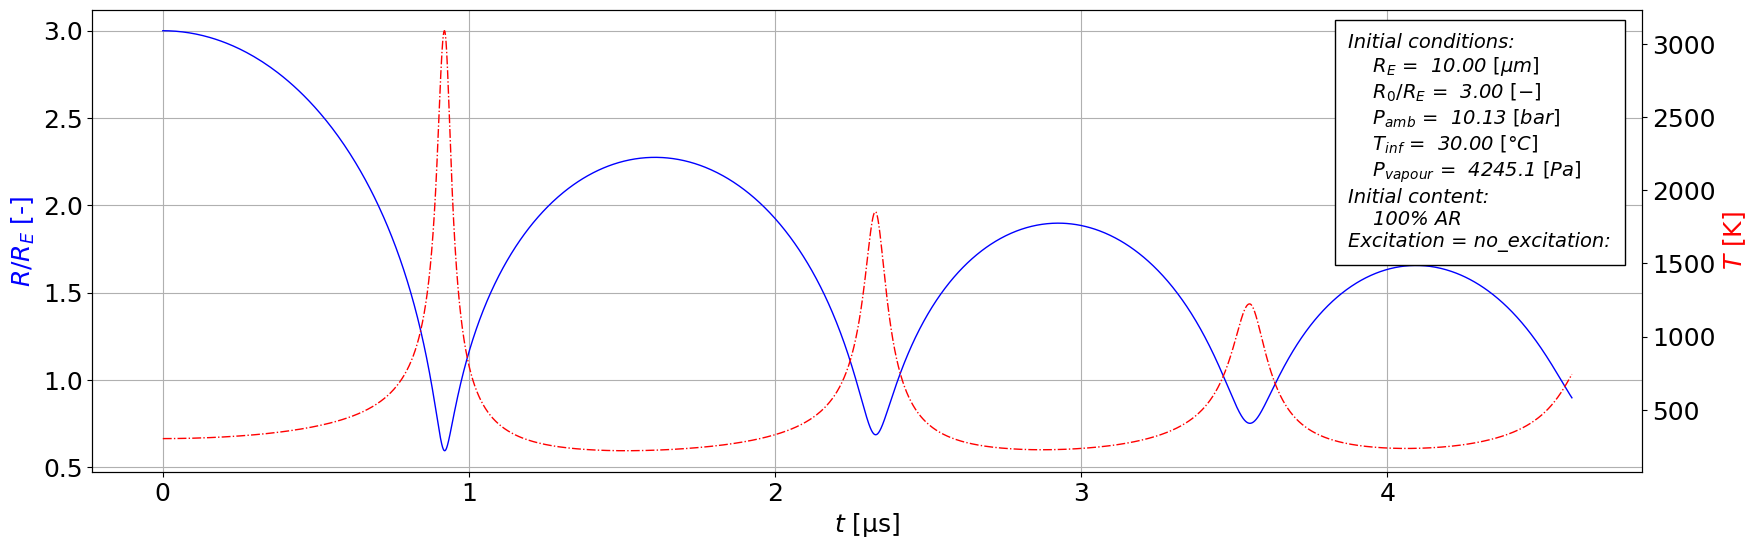

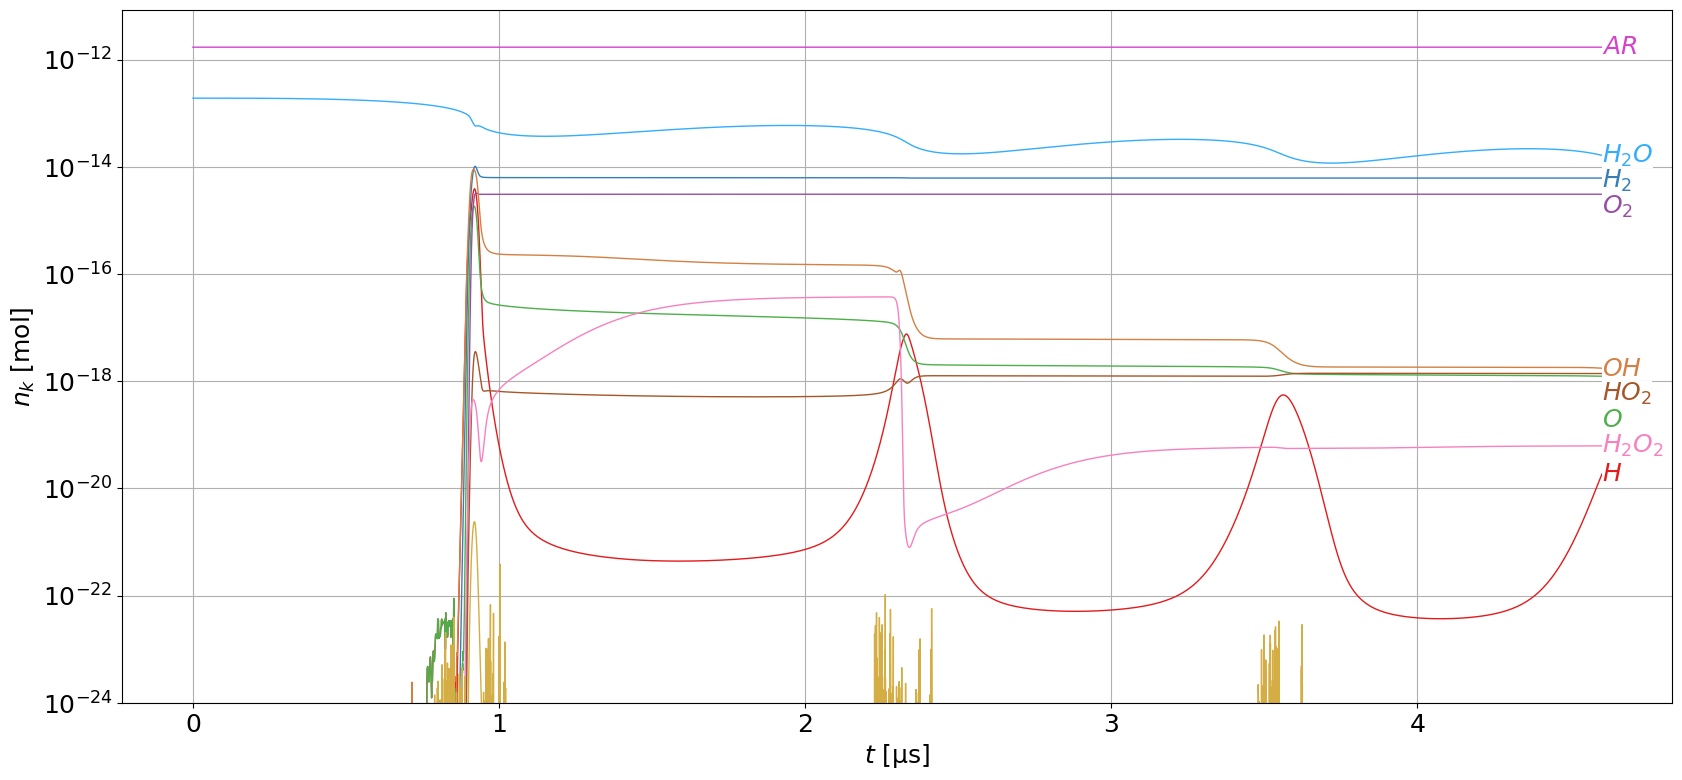

Control parameters:
    ID = 246
    R_E = 10.00 [um]
    ratio = 3.00 [-]
    P_amb = 10.13 [bar]
    alfa_M = 0.05 [-]
    T_inf = 30.00 [°C]
    P_v = 4245.13 [Pa]
    mu_L = 0.81 [mPa*s]
    surfactant = 1.00 [-]    
    excitation = 'no_excitation'
   )
    Initial content: 100% AR
Simulation info:
    error_code = 0
    elapsed_time = 4.02 [s]
    steps = 45629 [-]
Final state:
    R_final = 10.02 [um];   R_dot_final =3.8128175450138144e-17 [m/s];   T_final = 303.15 [K]
    n_H2_final = 6.15e-15 [mol]
    Final molar concentrations: [mol/cm^3]
        H     :   -4.888085297303167e-22;    H2    :    1.460089596925646e-06;    O     :  -3.9288291832440866e-16;    O2    :    7.299797728269972e-07;    
        OH    :   1.6404973834844206e-19;    H2O   :   1.6842204457223525e-06;    N2    :  -1.0463995208277721e-27;    HO2   :  -2.1191484204705575e-12;    
        H2O2  :   1.3323038705200442e-10;    AR    :   0.00040382496778300613;    HE    :                      0.0;    OHEX  :    

In [31]:
"""Plot a certain simulation"""

# converts a line of all_data to a dictionary containing the control parameters (cpar)
def line_to_dict(line):
    # check 'full_bubble_model.py' settings
    if (de.enable_heat_transfer != line['enable_heat_transfer'] or
        de.enable_evaporation != line['enable_evaporation'] or
        de.enable_reactions != line['enable_reactions'] or
        de.enable_dissipated_energy != line['enable_dissipated_energy'] or
        de.target_specie != line['target_specie'] or
        de.excitation_type != line['excitation_type']):
        print(colored(f'Error: the settings of \'full_bubble_model.py\' do not match the current settings', 'red'))

    gases = str(line['gases'])
    gases = [int(index) for index in gases.split(' ') if index != '']
    fractions = str(line['fractions'])
    fractions = [float(frac) for frac in fractions.split(' ') if frac != '']

    cpar = de.dotdict(dict(
        ID = line['ID'],                  # ID of control parameter (not used during calculation)
    # Initial conditions:
        R_E = line['R_E'],                # bubble equilibrium radius [m]
        ratio = line['ratio'],            # initial radius / equilibrium radius R_0/R_E [-]
        gases = gases,                    # indexes of species in initial bubble (list of species indexes)
        fractions = fractions,            # molar fractions of species in initial bubble (list of fractions for every gas)
    # Ambient parameters:
        P_amb = line['P_amb'],            # ambient pressure [Pa]
        T_inf = line['T_inf'],            # ambient temperature [K]
    # Liquid parameters:
        alfa_M = line['alfa_M'],          # water accommodation coefficient [-]
        P_v = line['P_v'],                # vapour pressure [Pa]
        mu_L = line['mu_L'],              # dynamic viscosity [Pa*s]
        c_L = line['c_L'],                # sound speed [m/s]
        surfactant = line['surfactant'],  # surfactant (surface tension modfier) [-]
    ))

    # Excitation parameters:
    for arg in de.excitation_args:
        cpar[arg] = line[arg]

    return cpar

cpar = line_to_dict(good_data.iloc[1])   # choose the most energy efficient one
de.plot(cpar)